In [1]:
import sys, os, re
from glob import glob
import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio

pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',70)
sys.path.insert(0, '/Users/SRIWOPE/Documents/python/config/')
from edw_wallet import *

sys.path.insert(0, '/Users/SRIWOPE/Documents/python/script/')
from run_query import run_sql

from datetime import datetime
from typing import Dict, Any, Tuple, List

import copy 
import hashlib

import joblib

import warnings
warnings.filterwarnings('ignore')

import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

from data_processing import DataProcessor

run_sql took 1.20 minutes to run.


In [3]:
ls results/models/

cat_model.joblib               model_params.joblib
data_processor.joblib          rf_model.joblib
feature_importances.joblib     stacked_ensemble_model.joblib
gb_model.joblib                voting_ensemble_model.joblib
lgb_model.joblib               xgb_model.joblib


In [4]:
model_path = 'results/models/'
loaded_model = joblib.load(model_path+'rf_model.joblib')
loaded_model

RandomForestRegressor(bootstrap=False, max_features='sqrt', n_estimators=1000,
                      n_jobs=-1, random_state=42)

In [50]:

stack_loaded_model = joblib.load(model_path+'stacked_ensemble_model.joblib')
stack_loaded_model

StackingRegressor(cv=5,
                  estimators=[('rf',
                               RandomForestRegressor(bootstrap=False,
                                                     max_features='sqrt',
                                                     n_estimators=1000,
                                                     n_jobs=-1,
                                                     random_state=42)),
                              ('gb',
                               GradientBoostingRegressor(learning_rate=0.05,
                                                         max_depth=9,
                                                         min_samples_split=5,
                                                         n_estimators=500,
                                                         random_state=42,
                                                         subsample=0.8)),
                              ('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample...
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=1000, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...)),
                              ('lgb',
                               LGBMRegressor(force_col_wise=True, max_depth=9,
                                             min_child_weight=3,
                                             min_data_in_leaf=10,
                                             n_estimators=1000, random_state=42,
                                             verbose=-1)),
                              ('cat',
                               <catboost.core.CatBoostRegressor object at 0x33da01070>)],
                  final_estimator=Ridge(), n_jobs=-1)

In [14]:
xgb_loaded_model = joblib.load(model_path+'xgb_model.joblib')
xgb_loaded_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

Available models with feature importances: ['rf', 'gb', 'xgb', 'lgb', 'cat']

Top 10 most important features (Random Forest):
COMPANY_CODE_XO         0.136354
MARKET_TIER_COMBO       0.131414
SALES_TIER              0.098122
CIRCUIT_AGE_DAYS        0.071237
FIRST_LGNTD             0.041486
FIRST_LAT               0.040404
LVL_4_PRD_NM            0.035792
ENDPOINT_DISTANCE_KM    0.031540
MARGIN                  0.025815
REV_TYPE_FLAG_C         0.025584
dtype: float64

Top 10 most important features (XGBoost):
COMPANY_CODE_XO              0.673787
CIR_TECH_TYPE_WIRELESS       0.077992
CIR_TECH_TYPE_TDM            0.075118
FIRST_ADDR_TYPE_CODE_SITE    0.042869
TECH_ONNET_COMBO             0.023206
MARKET_TIER_COMBO            0.015818
COST_TYPE_FLAG_S             0.011111
REV_TYPE_FLAG_C              0.010565
IN_FOOTPRINT_Y               0.005707
LOG_PORT_SPEED               0.003926
dtype: float32

Top 10 most important features (LightGradientBoost):
FIRST_LGNTD             3290
FIRST_LA

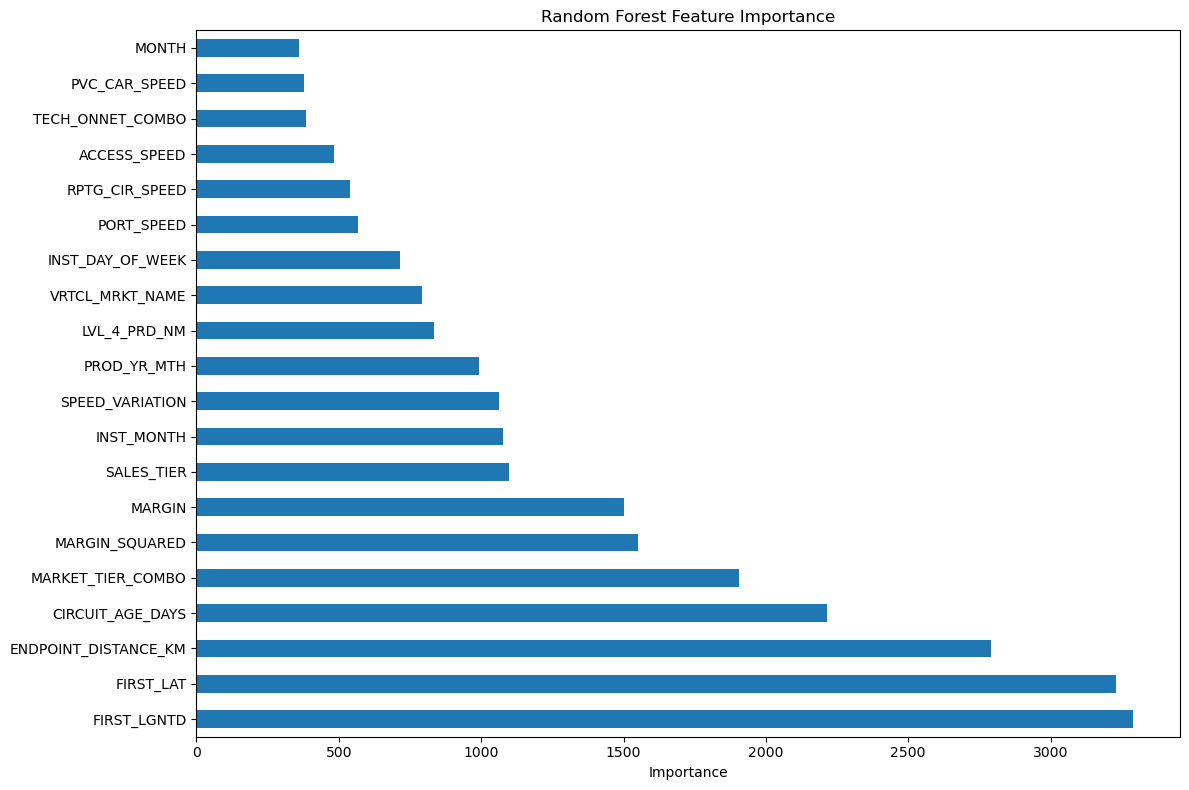

In [8]:
feature_importances = joblib.load(model_path + 'feature_importances.joblib')

# Get keys to see what models have feature importances
print("Available models with feature importances:", list(feature_importances.keys()))

# View Random Forest feature importance
rf_importance = feature_importances['rf']
print("\nTop 10 most important features (Random Forest):")
print(rf_importance.head(10))

# View XGBoost feature importance if available
if 'xgb' in feature_importances:
    xgb_importance = feature_importances['xgb']
    print("\nTop 10 most important features (XGBoost):")
    print(xgb_importance.head(10))

if 'lgb' in feature_importances:
    lgb_importance = feature_importances['lgb']
    print("\nTop 10 most important features (LightGradientBoost):")
    print(lgb_importance.head(10))

# Plot Random Forest feature importance
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
lgb_importance.head(20).plot(kind='barh')
plt.title('Random Forest Feature Importance')
plt.xlabel('Importance')
plt.tight_layout()
plt.savefig('rf_feature_importance.png')  # Save to file
plt.show()  # Display plot

In [51]:
frn_data = run_sql('''
                    select distinct a.CIR_ID,a.NASP_ID, NASP_NM, DOM_INTL_FLAG,	INT_EXT_FLAG,	LVL_4_PRD_NM,CIR_INST_DATE,CIR_DISC_DATE,VRTCL_MRKT_NAME,
                    SALES_TIER,	SR_CRCTP,	RPTG_CRCTP,	RPTG_CIR_SPEED,	ACCESS_SPEED,	ACCESS_SPEED_UP,	
                    PORT_SPEED,	PVC_CAR_SPEED,		ACCESS_DISC,		PORT_DISC,	PVC_CAR_DISC,		OTHER_DISC,	OTHER_ADJ,		
                    	TOTAL_REV-(TOTAL_COST + OCC_COST_NONAFLT_M6364) MARGIN,
                    
                    
                    REV_TYPE_FLAG,	COST_TYPE_FLAG,	FIRST_ADDR_TYPE_CODE,
                    FIRST_CITY,	FIRST_STATE,	FIRST_ZIP,
                    FIRST_ONNET,	FIRST_INREGION,	FIRST_XOLIT,	FIRST_LATA,
                    ONNET_PROV,	COMPANY_CODE,	VRD_FLAG,	OPCO_REV,	IN_FOOTPRINT,	NASP_TYPE,
                    CIR_TECH_TYPE,	CIR_BILL_TYPE,	PROGRAM,	VENDOR,
                    BIZ_CASE, FIRST_LAT,	FIRST_LGNTD,
                    SECOND_LAT,	SECOND_LGNTD,	IEN_PROV,	DIV_PORT,	DIV_ACCESS, PROD_YR_MTH
                           
                           from edw_sr_vw.rt_cir_single_row_addr a
                           
                
                    where 
                    PROD_YR_MTH = 202501
                    and VENDOR like '%FRN%'
                    and CIR_ID in (sel CIR_ID from EDW_GLOB_OPS_VW.CIRCUIT_TDM_TD_VW
                                        where DISCO_ORD_NUM is null
                                        group by CIR_ID)
                    
 
                    
                    ''')

run_sql took 13.70 seconds to run.


In [16]:
def align_features_with_model(new_data_processed, model):
    """
    Align features in new data with those the model was trained on.

    Args:
        new_data_processed: Processed data for prediction
        model: Trained model

    Returns:
        DataFrame with aligned features
    """
    # Get the features expected by the model
    if hasattr(model, 'feature_names_in_'):
        expected_features = model.feature_names_in_
    elif hasattr(model, 'get_booster'):
        expected_features = model.get_booster().feature_names
    elif hasattr(model, 'feature_importances_'):
        expected_features = model.feature_names
    else:
        raise ValueError("Cannot determine model features")

    # Create a DataFrame with all expected features initialized to 0
    aligned_data = pd.DataFrame(0, index=new_data_processed.index, columns=expected_features)

    # Copy values from processed data where features match
    for col in new_data_processed.columns:
        if col in aligned_data.columns:
            aligned_data[col] = new_data_processed[col]

    # Log which features were missing and added
    missing_features = [f for f in expected_features if f not in new_data_processed.columns]
    extra_features = [f for f in new_data_processed.columns if f not in expected_features]

    print(f"Added {len(missing_features)} missing features")
    print(f"Excluded {len(extra_features)} extra features")

    return aligned_data


In [52]:
preprocessor_data = joblib.load(model_path+'data_processor.joblib')
preprocessor = DataProcessor(random_state=preprocessor_data['random_state'])


In [53]:
preprocessor.robust_scaler = preprocessor_data['robust_scaler']
preprocessor.standard_scaler = preprocessor_data['standard_scaler']

preprocessor.target_encoder = preprocessor_data['target_encoder']
preprocessor.knn_imputer = preprocessor_data['knn_imputer']

In [56]:
frn_data['DISCO_DURATION'] = 0

processed_data = preprocessor.preprocess_data(frn_data, is_training = False)
if 'DISCO_DURATION' in processed_data.columns:
    processed_data = processed_data.drop(columns=['DISCO_DURATION'])

# Align the features with what the model expects
aligned_data = align_features_with_model(processed_data, xgb_loaded_model)

Starting data preprocessing...
After distribution - Target column has 1045 non-NaN values out of 1045 rows
Engineering features...
Feature engineering complete. New shape: (1045, 92)
After feature engineering - Target column NaN count: 0
Before one-hot encoding - Target column exists: True
  Target column type: int64
  Target column non-NaN values: 1045
Categorical columns to encode: ['DOM_INTL_FLAG', 'INT_EXT_FLAG', 'REV_TYPE_FLAG', 'COST_TYPE_FLAG', 'FIRST_ADDR_TYPE_CODE', 'FIRST_ONNET', 'FIRST_INREGION', 'FIRST_XOLIT', 'ONNET_PROV', 'COMPANY_CODE', 'VRD_FLAG', 'OPCO_REV', 'IN_FOOTPRINT', 'NASP_TYPE', 'CIR_TECH_TYPE', 'CIR_BILL_TYPE', 'PROGRAM', 'BIZ_CASE', 'IEN_PROV', 'DISTANCE_BUCKET', 'RPTG_CIR_SPEED_TIER', 'ACCESS_SPEED_TIER', 'PORT_SPEED_TIER', 'PVC_CAR_SPEED_TIER', 'SPEED_TIER', 'TECH_BILL_COMBO']
After one-hot encoding - Target column exists: True
  Target column non-NaN values: 1045
Preprocessing complete. Final shape: (1045, 112)
After distribution - Target column NaN count:

In [57]:
predictions = xgb_loaded_model.predict(aligned_data)

In [58]:
prediction_df = pd.concat([frn_data['CIR_ID'],pd.DataFrame(predictions)], axis = 1,ignore_index = True)
prediction_df.columns = ['CIR_ID','DURATION_PREDICT']

In [26]:
prediction_df

,CIR_ID,DURATION_PREDICT
0,358595856,15.261393
1,BCBK98MP0001,0.633811
2,P1891523,-0.408272
3,T6BKK44D0001,-0.050167
4,MVBFV8PG0001,-0.031287
...,...,...
1040,87718575,0.071234
1041,T6BLGDNL0001,0.852363
1042,MGBKLXRH0001,-0.417510
1043,613470PTERINAIUBW,5.214062


In [28]:
prediction_df[prediction_df['DURATION_PREDICT'] < 0].min()

CIR_ID                0C593Z
DURATION_PREDICT   -1.848892
dtype: object

# Stacked model

In [65]:
if hasattr(stack_loaded_model, 'estimators_'):
    base_model = stack_loaded_model.estimators_[0][1]
    aligned_data = align_features_with_model(processed_data, stack_loaded_model)
    stack_predictions = stack_loaded_model.predict(aligned_data)

Added 1 missing features
Excluded 63 extra features


ValueError: Input X contains NaN.
GradientBoostingRegressor does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [63]:
 stack_loaded_model.estimators_[0]

RandomForestRegressor(bootstrap=False, max_features='sqrt', n_estimators=1000,
                      n_jobs=-1, random_state=42)

In [ ]:
    # def get_original_columns(self) -> List[str]:
    #     """Map encoded features back to original columns and get their importance"""
    #     try:
    #         # get top 30 feature importance
    #         top_features = self.feature_importance.index[:30]
            
    #         essential_cols = [
             
    #             'ACCESS_SPEED',
    #             'PORT_SPEED',
    #             'RPTG_CIR_SPEED',
    #             'SR_CRCTP',
    #             'RPTG_CRCTP',
    #             'VRTCL_MRKT_NAME',
    #             'CIR_TECH_TYPE',
    #             'CIR_BILL_TYPE'
    #         ]

    #         exclude_cols = [
    #             'DISCO_ORD_NUM',
    #             'DISCO_DATE_BCOM',
    #             'DISCO_DATE_ORDERING_STRT',
    #             'DISCO_DURATION',
    #             'CIR_DISC_DATE',
    #             'PROD_YR_MTH',
    #             'ACCESS_DISC',
    #             'PORT_DISC',
    #             'OTHER_DISC',
    #             'PVC_CAR_DISC',
    #             'TOTAL_DISC' 
                
    #         ]
            
    #         orig_col = []
    #         for i in self.feature_importance.index[:30]:
    #             for c in train_data.columns:
    #                 if (c in i and
    #                     c not in exclude_cols and
    #                     'DISC' not in c.upper() and
    #                     'DATE' not in c.upper()):
    #                     orig_col.append(c)
                    
    #         required_cols= list(set(essential_cols + orig_col) - set(exclude_cols))

    #         print("\n=== Column Importance ===")
    #         print(f'Total columns required: {len(required_cols)}')
    #         for c in required_cols:
    #             print(c)
    #         return required_cols

    #     except Exception as e:
    #         logger.error(f'Error getting original columns: {str(e)}')
    #         raise


In [29]:
def parse_results_file(file_path):
    with open(file_path, 'r') as f:
        content = f.read()

    results = {}
    models = ['rf', 'gb', 'xgb', 'lgb', 'cat', 'stacked_ensemble', 'voting_ensemble']

    for model in models:
        # Try to find the model section
        pattern = f"{model}:.*?R2: ([0-9.]+).*?MAE: ([0-9.]+).*?MSE: ([0-9.]+).*?RMSE: ([0-9.]+)"
        match = re.search(pattern, content, re.DOTALL)

        if match:
            results[model] = {
                'R2': float(match.group(1)),
                'MAE': float(match.group(2)),
                'MSE': float(match.group(3)),
                'RMSE': float(match.group(4))
            }

    return results

In [40]:
results_dir = os.path.dirname(model_path)
results_files = glob(os.path.join(results_dir,'*.txt')) + glob(os.path.join(results_dir,'*.csv'))+ glob(os.path.join(results_dir,'*.joblib'))

In [45]:
print("Found the following potential results files:")
for f in results_files:
    print(f' - {f}')

if results_files:
    try:
        results = parse_results_file(results_files[0])
        print('\nExtracted metrics:')
        for model, metrics in results.items():
            print(f'{model}: {metrics}')
    except Exception as e:
        print(f'Error parsing file: {str(e)}')

Found the following potential results files:
 - results/models/voting_ensemble_model.joblib
 - results/models/stacked_ensemble_model.joblib
 - results/models/xgb_model.joblib
 - results/models/data_processor.joblib
 - results/models/rf_model.joblib
 - results/models/lgb_model.joblib
 - results/models/gb_model.joblib
 - results/models/feature_importances.joblib
 - results/models/cat_model.joblib
 - results/models/model_params.joblib
Error parsing file: 'utf-8' codec can't decode byte 0x80 in position 0: invalid start byte


In [46]:
def plot_model_metrics_comparison(results):
    """
    Create a comprehensive comparison of multiple metrics across different models.

    Args:
        results: Dictionary with model names as keys and performance metrics as values

    Returns:
        matplotlib Figure
    """
    # Extract metrics and model names
    model_names = list(results.keys())
    metrics = ['R2', 'MAE', 'RMSE']  # Focus on key metrics

    # Create DataFrame for plotting
    data = []
    for model_name, model_metrics in results.items():
        for metric in metrics:
            data.append({
                'Model': model_name,
                'Metric': metric,
                'Value': model_metrics[metric]
            })

    df_plot = pd.DataFrame(data)

    # Sort models by R2 score for consistent ordering
    r2_values = {model: metrics['R2'] for model, metrics in results.items()}
    sorted_models = sorted(r2_values.keys(), key=lambda x: r2_values[x], reverse=True)

    # Create figure with subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 8))

    # Color palette
    colors = sns.color_palette('viridis', len(model_names))
    model_colors = {model: color for model, color in zip(sorted_models, colors)}

    # Plot each metric
    for i, metric in enumerate(metrics):
        metric_data = df_plot[df_plot['Metric'] == metric]

        # Sort by model order
        metric_data['Model'] = pd.Categorical(
            metric_data['Model'],
            categories=sorted_models,
            ordered=True
        )
        metric_data = metric_data.sort_values('Model')

        # Define bar colors
        bar_colors = [model_colors[model] for model in metric_data['Model']]

        # Plot
        bars = axes[i].bar(
            metric_data['Model'],
            metric_data['Value'],
            color=bar_colors,
            alpha=0.7,
            edgecolor='black'
        )

        # Add value labels
        for bar in bars:
            height = bar.get_height()
            axes[i].text(
                bar.get_x() + bar.get_width()/2.,
                height,
                f'{height:.4f}',
                ha='center',
                va='bottom',
                rotation=90,
                fontsize=9
            )

        # Set title and labels
        axes[i].set_title(f'{metric} Comparison', fontsize=14)
        axes[i].set_ylabel('Score' if metric == 'R2' else 'Error', fontsize=12)

        # Rotate x-axis labels
        axes[i].set_xticklabels(metric_data['Model'], rotation=45, ha='right', fontsize=10)

        # Add grid
        axes[i].grid(axis='y', linestyle='--', alpha=0.3)

        # For R2, higher is better, so invert colormap
        if metric == 'R2':
            # Add reference line for perfect prediction
            axes[i].axhline(y=1.0, color='red', linestyle='--', alpha=0.5)
            axes[i].set_ylim(min(0.8, min(metric_data['Value']) - 0.05), 1.02)
        else:
            # For error metrics, lower is better
            axes[i].set_ylim(0, max(metric_data['Value']) * 1.1)

    # Add a common title
    plt.suptitle('Model Performance Metrics Comparison', fontsize=16, y=0.98)

    # Add interpretation guide
    interpretation_text = (
        "R²: Higher is better (closer to 1.0)\n"
        "MAE: Lower is better (Mean Absolute Error)\n"
        "RMSE: Lower is better (Root Mean Squared Error)"
    )

    fig.text(0.5, 0.01, interpretation_text, ha='center', fontsize=10,
             bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7))

    # Tight layout
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])

    return fig

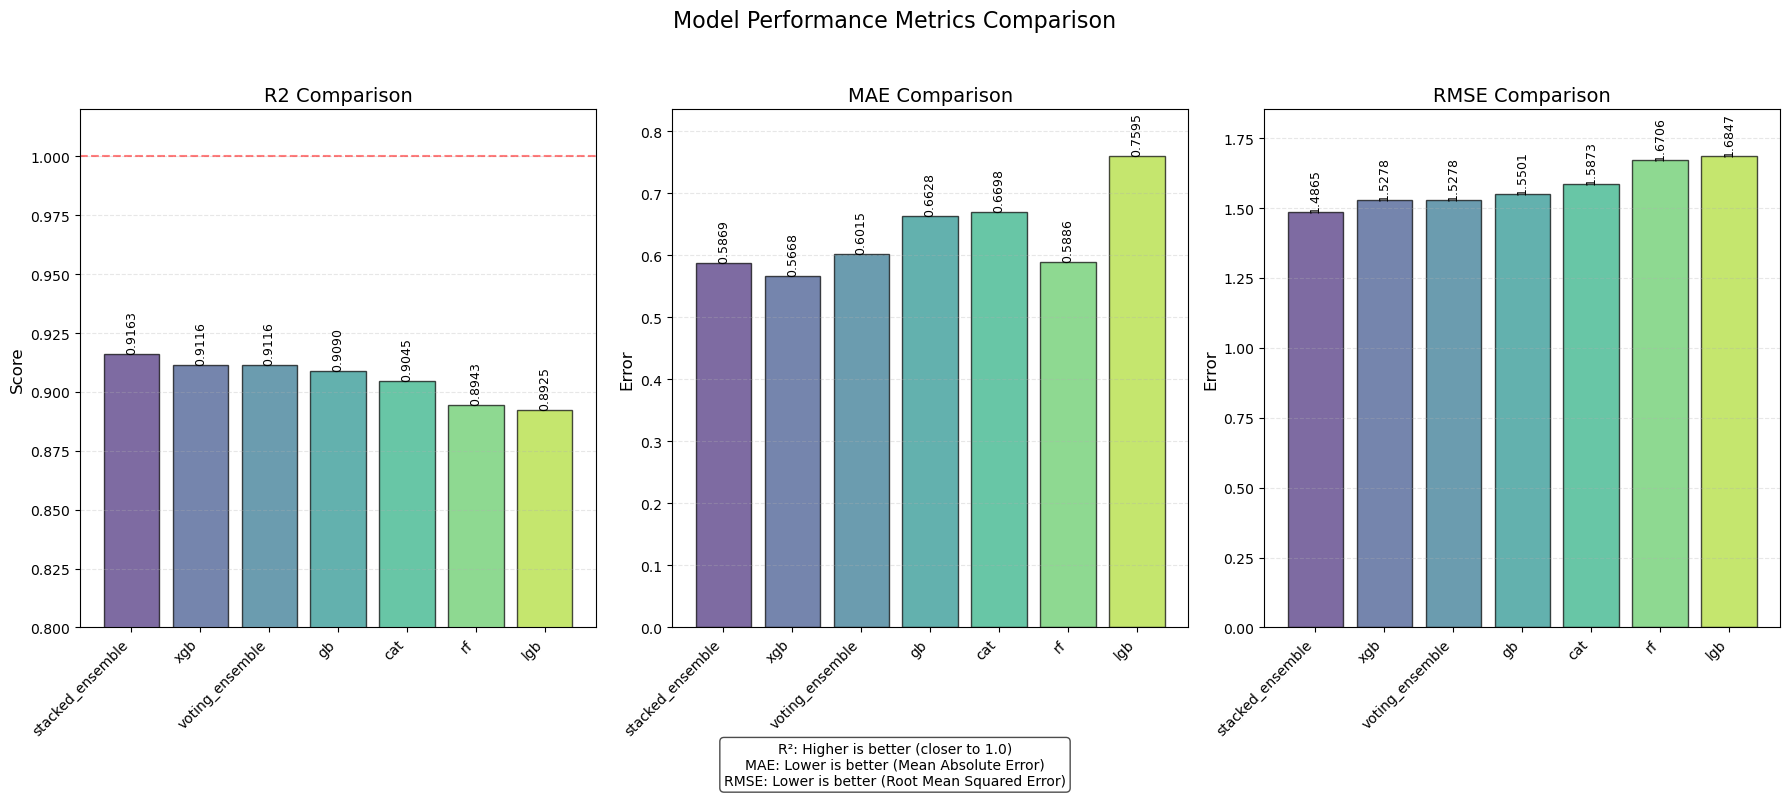

In [47]:
results = {
    'rf': {'R2': 0.8943, 'MAE': 0.5886, 'MSE': 2.7910, 'RMSE': 1.6706},
    'gb': {'R2': 0.9090, 'MAE': 0.6628, 'MSE': 2.4028, 'RMSE': 1.5501},
    'xgb': {'R2': 0.9116, 'MAE': 0.5668, 'MSE': 2.3342, 'RMSE': 1.5278},
    'lgb': {'R2': 0.8925, 'MAE': 0.7595, 'MSE': 2.8384, 'RMSE': 1.6847},
    'cat': {'R2': 0.9045, 'MAE': 0.6698, 'MSE': 2.5195, 'RMSE': 1.5873},
    'stacked_ensemble': {'R2': 0.9163, 'MAE': 0.5869, 'MSE': 2.2098, 'RMSE': 1.4865},
    'voting_ensemble': {'R2': 0.9116, 'MAE': 0.6015, 'MSE': 2.3343, 'RMSE': 1.5278}
}
fig = plot_model_metrics_comparison(results)
plt.savefig('model_metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()